In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta
# from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# database_path = "../Resources/hawaii.sqlite"
# engine = create_engine(f"sqlite:///{database_path}")

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
print(engine)

Engine(sqlite:///Resources/hawaii.sqlite)


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

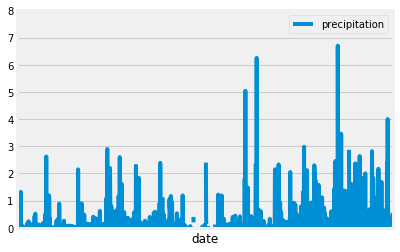

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last date from Measurement --- 2017-08-23
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert string to date format
last_date = datetime.strptime(str(last_date), '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database then convert datetime to date
year_ago = (last_date - dt.timedelta(days=365)).date()

#Convert datetime to string
year_ago=year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
one_yr_data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_yr_data, columns=['date','precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.ylim(0,8)
plt.xticks([])
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Choose the station with the highest number of temperature observations.
most_active_station=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
print(most_active_station)

USC00519281


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).one()

(54.0, 85.0, 71.66378066378067)

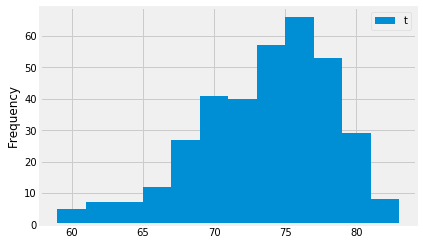

In [16]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

one_yr_highest_tobs=session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.date>=year_ago).all()

tobs = list(np.ravel(one_yr_highest_tobs))
#print(tobs)
num_bins = 12
plt.hist(tobs, num_bins)
plt.ylabel('Frequency')
plt.legend('tobs')
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Assumption: trip was on April 15-26, 2018.  Manually setting paremeters to dates from previous year
start_date = '2017-04-15'
end_date = '2017-04-26'
temps_df = pd.DataFrame(calc_temps(start_date, end_date), columns=['Min Temp (F)','Avg Temp (F)','Max Temp (F)'])
temps_df

,Min Temp (F),Avg Temp (F),Max Temp (F)
0,67.0,73.77027,83.0


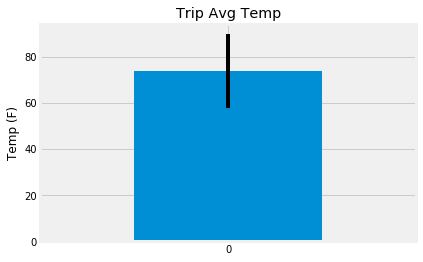

In [20]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

# Use the average temperature for the y value
avg_temp = temps_df['Avg Temp (F)']

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=temps_df['Max Temp (F)'][0]-temps_df['Min Temp (F)'][0]

plt.xticks([])
plt.ylabel("Temp (F)")
avg_temp.plot(kind='bar', yerr=yerr)
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,\
                         Station.elevation, func.sum(Measurement.prcp)).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

#Adding results to a dataframe for better presentation of data
rainfall_df=pd.DataFrame(rainfall, columns=['Station','Name', 'Latitude', 'Longitude', 'Elevation','Total Precipitation'])
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,7.40
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.24
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.97
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,3.17
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.01
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.68
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [171]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-04-15'
end_date = '2017-04-26'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")
date_array = (start + dt.timedelta(days=x) for x in range(0, (end-start).days))

vacation_dates=[]
month_day=[]
for date_object in date_array:
    #set full dates in an array
    vacation_dates.append(date_object.strftime("%Y-%m-%d"))
    # Stip off the year and save a list of %m-%d strings
    month_day.append(date_object.strftime("%m-%d"))
month_day

['04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21',
 '04-22',
 '04-23',
 '04-24',
 '04-25']

In [172]:
# # Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for x in month_day:
    normals.append(daily_normals(x))

normals   

[[(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)],
 [(64.0, 72.73684210526316, 80.0)],
 [(66.0, 72.32142857142857, 78.0)],
 [(65.0, 72.92727272727272, 84.0)],
 [(65.0, 73.01818181818182, 79.0)],
 [(67.0, 73.3103448275862, 80.0)],
 [(66.0, 73.96551724137932, 83.0)]]

In [179]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#Convert list of list of tuples --> list of tuples
normals_list = [x[0] for x in normals]
normals_list

#convert list to df
daily_normals_df = pd.DataFrame(normals_list,columns=['tmin','tave','tmax'])
daily_normals_df

,tmin,tave,tmax
0,61.0,71.793103,79.0
1,62.0,71.553571,81.0
2,65.0,71.931034,77.0
3,67.0,72.491525,77.0
4,65.0,72.421053,83.0
5,64.0,72.736842,80.0
6,66.0,72.321429,78.0
7,65.0,72.927273,84.0
8,65.0,73.018182,79.0
9,67.0,73.310345,80.0


In [180]:
#Convert vacation_dates to a dataframe
dates_df=pd.DataFrame(vacation_dates,columns=['date'])
dates_df

,date
0,2017-04-15
1,2017-04-16
2,2017-04-17
3,2017-04-18
4,2017-04-19
5,2017-04-20
6,2017-04-21
7,2017-04-22
8,2017-04-23
9,2017-04-24


In [190]:
#Merge trip dates with normals result

date_normals_df=pd.merge(dates_df, daily_normals_df, left_index=True, right_index=True)
date_normals_df.set_index('date', inplace=True)
date_normals_df

,tmin,tave,tmax
date,,,
2017-04-15,61.0,71.793103,79.0
2017-04-16,62.0,71.553571,81.0
2017-04-17,65.0,71.931034,77.0
2017-04-18,67.0,72.491525,77.0
2017-04-19,65.0,72.421053,83.0
2017-04-20,64.0,72.736842,80.0
2017-04-21,66.0,72.321429,78.0
2017-04-22,65.0,72.927273,84.0
2017-04-23,65.0,73.018182,79.0


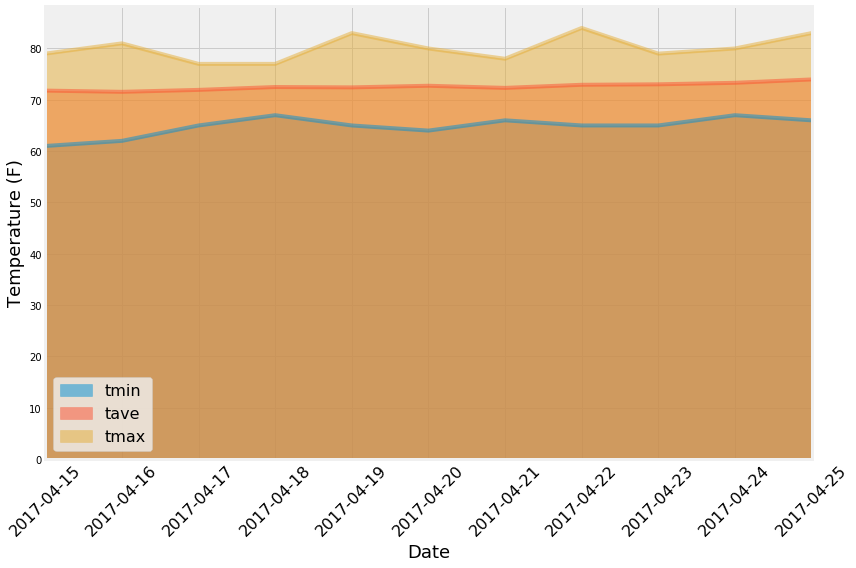

In [199]:
# Plot the daily normals as an area plot with `stacked=False`

x = np.arange(0,len(date_normals_df))
date_normals_df.plot.area(stacked = False, alpha = 0.5, figsize = (12,8))
plt.xlabel("Date", fontsize=18)
plt.ylabel("Temperature (F)", fontsize=18)
plt.xticks(x, dates_df.date, rotation = 45, fontsize=16)
plt.legend(fontsize=16)
# plt.title("Area Daily Normals for Trip from 02-14-2017 to 03-01-2017", fontsize=15)
plt.tight_layout()